In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
import xgboost as xgb
import pickle
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import brier_score_loss
from sklearn.calibration import calibration_curve


In [2]:
##############################################################################
##########                DATABASE FUNCTIONS                     #############
##############################################################################
#### Read function to import data from the SQL to a pandas dataframe.
def readSQL(query):
    import pandas as pd
    import sqlite3 as sql3
    db = sql3.connect(DB_FILE)
    df = pd.read_sql_query(query, db)
    db.close()
    return(df)

#### Write a pandas dataframe into an SQL table. Use overwrite=True if you want to delete 
#### first a pre-existent table with the same name. Use append=True if you want to append
#### the data in the dataframe to a pre-existent table.
def writeSQL(df,tablename,overwrite=False, append=False):
    import pandas as pd
    import sqlite3 as sql
    db = sql.connect(DB_FILE)
    if (overwrite):
        action = "replace"
    elif (append):
        action = "append"
    else: 
        action = "fail"
    df.to_sql(tablename, db, if_exists=action)
    db.close()
def listTables():
    import sqlite3 as sql3
    db = sql3.connect(DB_FILE)
    cur = db.cursor()
    cur.execute("SELECT name FROM sqlite_master WHERE type='table';")
    res = cur.fetchall()
    cur.close()
    db.close()
    return(res)

In [3]:
import os
cwd = os.getcwd()
DB_FILE = "%s\Data\loans.db" % cwd
#DB_FILE = "loans.db"
X_Train = readSQL('''SELECT * FROM X_train_scaled''')
Y_Train = readSQL('''SELECT * FROM Y_train''')
X_Train = X_Train.drop(["index"],axis=1)
Y_Train = Y_Train.drop(["index"],axis=1)
X_Dev = readSQL('''SELECT * FROM X_dev_scaled''')
X_Dev = X_Dev.drop(["index"],axis=1)
Y_Dev = readSQL('''SELECT * FROM Y_dev''')
Y_Dev = Y_Dev.drop(["index"],axis=1)
Y_Train = Y_Train.values.ravel()
Y_Dev = Y_Dev.values.ravel()

In [4]:
filename= "%s\Models\XGB_best_model.sav" % cwd
mod_xgb = pickle.load(open(filename, 'rb'))
filename= "%s\Models\logistic_best_model.sav" % cwd
mod_logistic = pickle.load(open(filename, 'rb'))

C:\Users\Kobi\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.19.1 when using version 0.20.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [5]:
pred_dev_log = mod_logistic.predict_proba(X_Dev)
pred_dev_xgb = mod_xgb.predict_proba(X_Dev)

In previous notebooks we have seen that xgb gives the highest AUC

In [6]:
dev_score_log = metrics.roc_auc_score(Y_Dev, pred_dev_log[:,1])
dev_score_xgb = metrics.roc_auc_score(Y_Dev, pred_dev_xgb[:,1])
print(dev_score_log)
print(dev_score_xgb)

0.6895065790533634
0.7041575954287301


At the same time, it is known that while theoretically logistic regression produces a forecast that is reliable, XGB does not necessarily  produce such a forecast.

Since the purpose of our project is ultimately to predict probabilities, in order to estimate risk and not to execute a binary forecast, in this notebook we will make the forecast produced by the XGB more reliable.

In [7]:
fop_dev_log, mpv_dev_log = calibration_curve(Y_Dev, pred_dev_log[:,1], n_bins=10, normalize=True)
fop_dev_xgb, mpv_dev_xgb = calibration_curve(Y_Dev, pred_dev_xgb[:,1], n_bins=10, normalize=True)

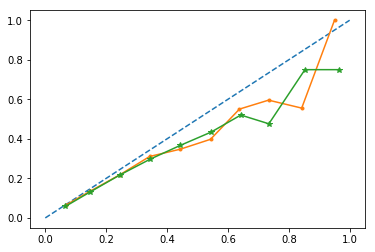

In [8]:
plt.plot([0, 1], [0, 1], linestyle='--')
# plot model reliability
plt.plot(mpv_dev_log, fop_dev_log, marker='.')
plt.plot(mpv_dev_xgb, fop_dev_xgb, marker='*')
plt.show()

In [10]:
brier_score_loss_log=brier_score_loss(Y_Dev, pred_dev_log[:,1])
brier_score_loss_xgb=brier_score_loss(Y_Dev, pred_dev_xgb[:,1])
print(brier_score_loss_log)
print(brier_score_loss_xgb)



0.13795208331363348
0.1361149630695373


In [11]:
##sigmoid calibration
calibrated = CalibratedClassifierCV(mod_xgb, method='sigmoid', cv=5)
calibrated.fit(X_Train, Y_Train)
# predict probabilities
pred_XGB_cal_sig = calibrated.predict_proba(X_Dev)[:, 1]

In [12]:
##Save the model
filename= "%s\Models\XGB_best_model_cal_sig.sav" % cwd
pickle.dump(calibrated, open( filename , 'wb'))

In [13]:
##isotonic calibration
calibrated = CalibratedClassifierCV(mod_xgb, method='isotonic', cv=5)
calibrated.fit(X_Train, Y_Train)
# predict probabilities
pred_XGB_cal_iso = calibrated.predict_proba(X_Dev)[:, 1]

In [14]:
##Save the model
filename= "%s\Models\XGB_best_model_cal_iso.sav" % cwd
pickle.dump(calibrated, open(filename, 'wb'))

In [15]:
fop_dev_xgb_sig, mpv_dev_xgb_cal_sig = calibration_curve(Y_Dev, pred_XGB_cal_sig, n_bins=10, normalize=True)
fop_dev_xgb_iso, mpv_dev_xgb_cal_iso = calibration_curve(Y_Dev, pred_XGB_cal_iso, n_bins=10, normalize=True)

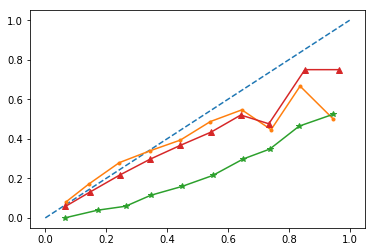

In [16]:
plt.plot([0, 1], [0, 1], linestyle='--')
# plot model reliability
plt.plot(mpv_dev_xgb_cal_sig, fop_dev_xgb_sig, marker='.')
plt.plot(mpv_dev_xgb_cal_iso, fop_dev_xgb_iso, marker='*')
plt.plot(mpv_dev_xgb, fop_dev_xgb, marker='^')
plt.show()

In [17]:

brier_score_loss_sig=brier_score_loss(Y_Dev, pred_XGB_cal_sig)
brier_score_loss_iso=brier_score_loss(Y_Dev, pred_XGB_cal_iso)
print(brier_score_loss_xgb)
print(brier_score_loss_sig)
print(brier_score_loss_iso)

0.1361149630695373
0.14222660711065233
0.13933904717771425


In [18]:
dev_score_xgb_sig = metrics.roc_auc_score(Y_Dev, pred_XGB_cal_sig)
dev_score_xgb_iso = metrics.roc_auc_score(Y_Dev, pred_XGB_cal_iso)
print(dev_score_xgb_sig)
print(dev_score_xgb_iso)
print(dev_score_xgb)

0.6997257761956649
0.7016643540965025
0.7041575954287301


We can see that the sigmoid and the isotonic gave very similar results.
Both models do give us less reliable results than the XGB prior to calibration, with a higher Brier score, and also showed a small decrease in AUC. Despite this decline, XGB still gave better results than the LR.

Therefore we chose to use the original XGB model, prior to calibration, to be our final model.

